# scTour's cross-data predictions

This notebook shows how to perform cross-data predictions, including predicting the developmental pseudotime, vector field, and latent space of a new dataset. Here one dataset from the developing human cortex is used as training data to train a scTour model. Another three datasets from the developing human cortex, brain organoids, and developing mouse cortex are used as test data. 

In [1]:
import sctour as sct
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Datasets

The first dataset (training data, 10X) is from the developing human cortex [Trevino et al., 2021, Cell](https://www.cell.com/cell/fulltext/S0092-8674(21)00942-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867421009429%3Fshowall%3Dtrue). The same set of cells used in the original study for reconstruction of the excitatory neuron developmental trajectory are used here. This dataset can be downloaded from [here](https://drive.google.com/drive/folders/1zGr_Gqio8zpJWAdLj0g66kN004PyYq_x?usp=sharing).

In [2]:
adata_train = sc.read('../../../../EX_development_data/EX_development_human_cortex_10X.h5ad')
adata_train.shape

(36318, 19073)

The three test datasets are from the developing human cortex (Drop-seq, [Polioudakis et al., 2019, Neuron](https://www.cell.com/neuron/fulltext/S0896-6273(19)30561-6?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0896627319305616%3Fshowall%3Dtrue)), brain organoids (10X, [Velasco et al., 2019, Nature](https://www.nature.com/articles/s41586-019-1289-x)), and developing mouse cortex (10X, [Bella et al., 2021, Nature](https://www.nature.com/articles/s41586-021-03670-5)). These three datasets can be downloaded from [here](https://drive.google.com/drive/folders/1zGr_Gqio8zpJWAdLj0g66kN004PyYq_x?usp=sharing).

In [3]:
adata_test1 = sc.read('../../../../EX_development_data/EX_development_human_cortex_DropSeq.h5ad')
adata_test1.shape

(27855, 21655)

In [4]:
adata_test2 = sc.read('../../../../EX_development_data/EX_development_human_organoids_10X.h5ad')
adata_test2.shape

(16032, 17545)

In [5]:
adata_test3 = sc.read('../../../../EX_development_data/EX_development_mouse_cortex_10X.h5ad')
adata_test3.shape

(73649, 16200)

The training dataset has substantial batch effects, as shown below.

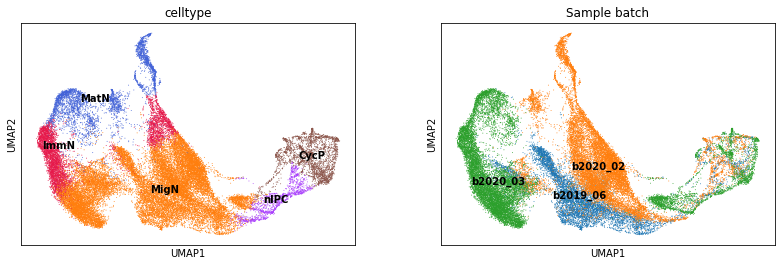

In [6]:
sc.pl.umap(adata_train, color=['celltype', 'Sample batch'], legend_loc='on data')

## Training

Count the number of genes detected in each cell. This is a necessary step before the scTour model training.

In [7]:
sc.pp.calculate_qc_metrics(adata_train, percent_top=None, log1p=False, inplace=True)

Select the highly variable genes and then use the intersection of these genes with genes detected in all the three test datasets for scTour model training.

In [8]:
sc.pp.highly_variable_genes(adata_train, flavor='seurat_v3', n_top_genes=1000, subset=True, batch_key='Sample batch')
ggs = adata_train.var_names.intersection(adata_test1.var_names).intersection(adata_test2.var_names).intersection(adata_test3.var_names)
adata_train = adata_train[:, ggs]
adata_train.shape

/home/ql312/software/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


(36318, 765)

log-transform the count before running scTour when you use the "nb" mode.

In [9]:
adata_train.X = np.log1p(adata_train.X)

Train the scTour model using 60% of all cells.

In [10]:
tnode = sct.train.Trainer(adata_train, percent=0.6)
tnode.train()

Epoch 184: 100%|██████████| 184/184 [30:21<00:00,  9.96s/epoch, train_loss=261, val_loss=260]


Infer the developmental pseudotime and latent space.

In [11]:
adata_train.obs['ptime'] = tnode.get_time()
mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.5, alpha_predz=0.5)
adata_train.obsm['X_TNODE'] = mix_zs

Trying to set attribute `.obs` of view, copying.


Generate a new UMAP embedding based on the inferred latent space.

In [12]:
adata_train = adata_train[np.argsort(adata_train.obs['ptime'].values), :]
sc.pp.neighbors(adata_train, use_rep='X_TNODE', n_neighbors=15)
sc.tl.umap(adata_train, min_dist=0.1)

Visualize the inferred developmental pseudotime on the UMAP embedding derived from the latent space. It's clear that both the pseudotime and latent representations of cells from scTour are not affected by the substantial batch effects.

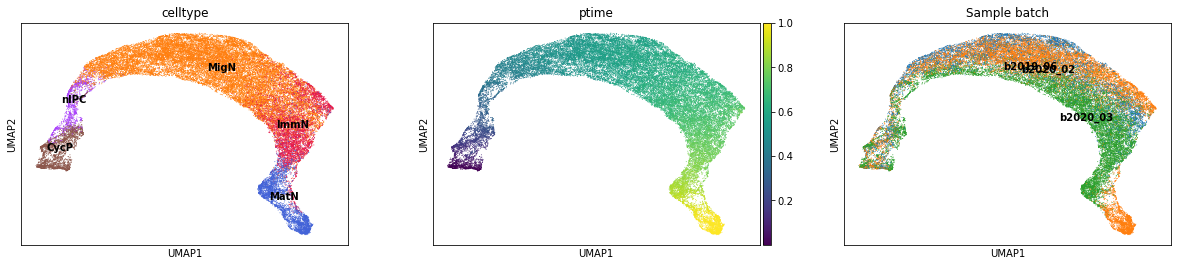

In [13]:
sc.pl.umap(adata_train, color=['celltype', 'ptime', 'Sample batch'], legend_loc='on data')

Infer and visualize the vector field.

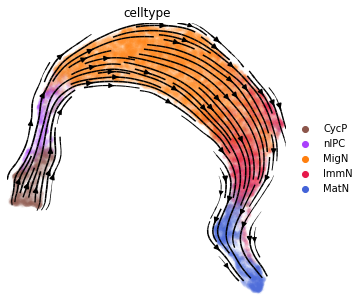

In [14]:
adata_train.obsm['X_VF'] = tnode.get_vector_field(adata_train.obs['ptime'].values, adata_train.obsm['X_TNODE'])
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
sct.vf.plot_vector_field(adata_train, zs_key='TNODE', vf_key='VF', use_rep_neigh='TNODE', ax=ax, color='celltype',  t_key='ptime', frameon=False, size=80, alpha=0.05)
plt.show()

## Prediction

Predict the developmental pseudotime for the cells from the three test datasets. Before the prediction, log-transform the raw counts of the three datasets because the model is trained using the 'nb' mode (default mode).

The prediction function "predict_time" returns the predicted pseudotime, as well as the predicted latent space by default. Similarly, users can adjust the two parameters alpha_z and alpha_predz based on their purposes. There is a "mode" parameter in this prediction function, controlling how to predict the latent space by whether or not taking into account the latent space from the training data. Setting this parameter to "coarse" means not considering the latent space from the training data. If you only want the pseudotime as the output, you can set the parameter "get_ltsp" to be False (True by default).

In [15]:
#test dataset 1
#test1_pred_t is the predicted pseudotime, and test1_pred_ltsp is the predicted latent space.
adata_test1.X = np.log1p(adata_test1.X)
test1_pred_t, test1_pred_ltsp, _, _ = tnode.predict_time(adata_test1, alpha_z=0.4, alpha_predz=0.6, mode='coarse')
adata_test1.obs['ptime'] = test1_pred_t
adata_test1.obsm['X_TNODE'] = test1_pred_ltsp

#test dataset 2
adata_test2.X = np.log1p(adata_test2.X)
test2_pred_t, test2_pred_ltsp, _, _ = tnode.predict_time(adata_test2, alpha_z=0.4, alpha_predz=0.6, mode='coarse')
adata_test2.obs['ptime'] = test2_pred_t
adata_test2.obsm['X_TNODE'] = test2_pred_ltsp

#test dataset 3
adata_test3.X = np.log1p(adata_test3.X)
test3_pred_t, test3_pred_ltsp, _, _ = tnode.predict_time(adata_test3, alpha_z=0.4, alpha_predz=0.6, mode='coarse')
adata_test3.obs['ptime'] = test3_pred_t
adata_test3.obsm['X_TNODE'] = test3_pred_ltsp

Visualize the predicted pseudotime.

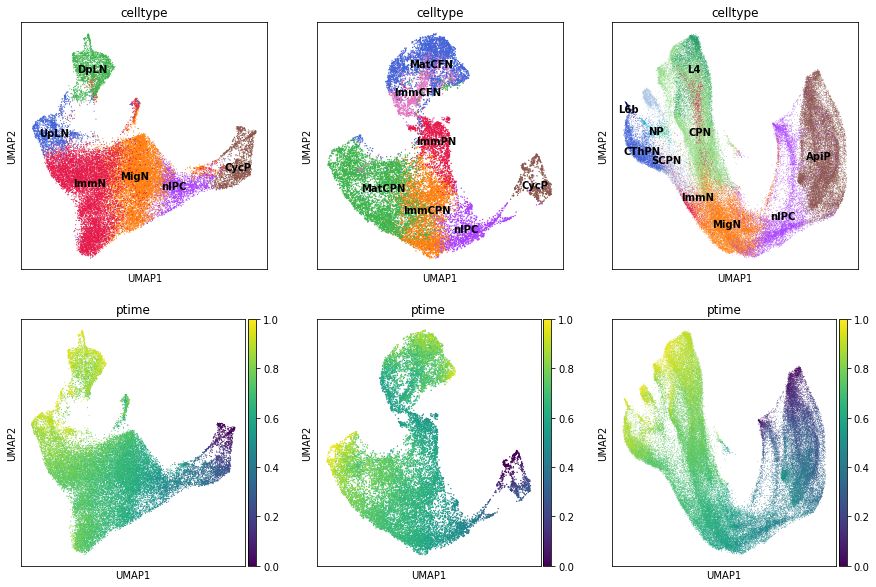

In [16]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
for i, adata in enumerate([adata_test1, adata_test2, adata_test3]):
    for j, pp in enumerate(['celltype', 'ptime']):
        vmin, vmax = (0, 1) if j == 1 else (None, None)
        sc.pl.umap(adata, color=pp, legend_loc='on data', show=False, ax=axs[j, i], legend_fontsize=10, vmin=vmin, vmax=vmax)
plt.show()

Predict the vector field based on the predicted latent space.

In [17]:
#test dataset 1
adata_test1.obsm['X_VF'] = tnode.get_vector_field(adata_test1.obs['ptime'].values, adata_test1.obsm['X_TNODE'])

#test dataset 2
adata_test2.obsm['X_VF'] = tnode.get_vector_field(adata_test2.obs['ptime'].values, adata_test2.obsm['X_TNODE'])

#test dataset 3
adata_test3.obsm['X_VF'] = tnode.get_vector_field(adata_test3.obs['ptime'].values, adata_test3.obsm['X_TNODE'])

Visualize the predicted vector field.

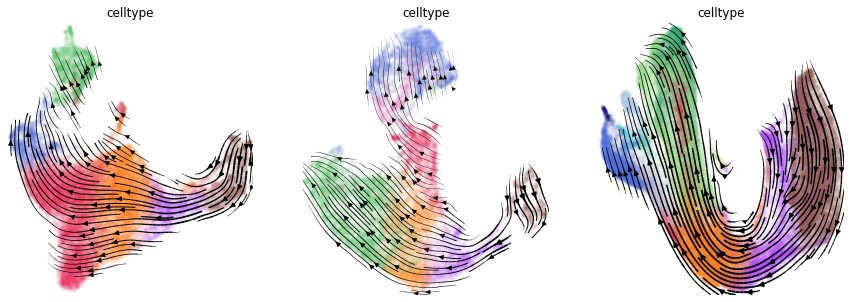

In [18]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
for i, adata in enumerate([adata_test1, adata_test2, adata_test3]):
    sct.vf.plot_vector_field(adata, zs_key='TNODE', vf_key='VF', use_rep_neigh='TNODE', ax=axs[i], color='celltype', t_key='ptime', legend_loc='none', frameon=False, size=80, alpha=0.05)
plt.show()

Generate a new UMAP embedding based on the predicted latent space for these three test datasets.

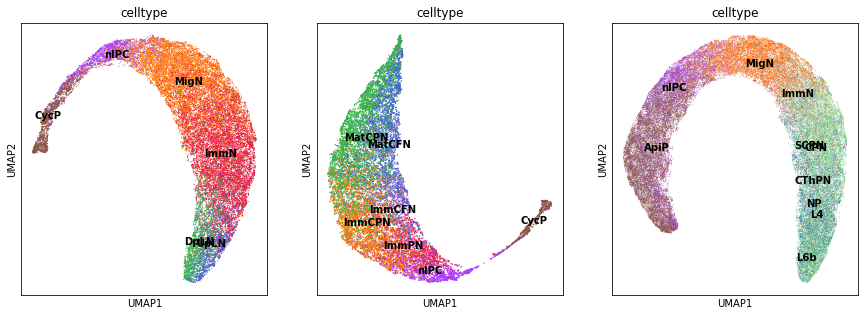

In [20]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
for i, adata in enumerate([adata_test1, adata_test2, adata_test3]):
    adata = adata[np.argsort(adata.obs['ptime'].values), :]
    sc.pp.neighbors(adata, use_rep='X_TNODE', n_neighbors=15)
    sc.tl.umap(adata, min_dist=0.1)
    sc.pl.umap(adata, color='celltype', legend_loc='on data', show=False, ax=axs[i])
plt.show()